# Quantified Sleep: Analysing results of grid search 

In [1]:
from pathlib import Path

import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
FIGSDIR = Path('../Figs/')

# Read in the unified dataset
df = pd.read_csv('../checkpoints/latest_results.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.shape

(47520, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47520 entries, 0 to 47519
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dataset         47520 non-null  object 
 1   algorithm       47520 non-null  object 
 2   n_features      47520 non-null  int64  
 3   train_examples  47520 non-null  object 
 4   RMSE            47520 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.8+ MB


In [6]:
df.sample(3)

dataset                                          algorithm  \
26232  matrixfactorization  <class 'sklearn.tree._classes.DecisionTreeRegr...   
5871    pre_markov_mice_15  <class 'sklearn.linear_model._coordinate_desce...   
41379       multi_imp_50it  <class 'sklearn.linear_model._coordinate_desce...   

       n_features train_examples       RMSE  
26232          18      (435, 18)  12.272938  
5871            8      (6336, 8)   8.398631  
41379          40      (435, 40)   8.069071

In [7]:
# Clean up algorithm names
df['algorithm'] = df['algorithm'].apply(lambda name: name.split('.')[-1].split("'")[0])

# Clean up train_examples
df['train_examples'] = df['train_examples'].apply(lambda v: int(v.split(',')[0][1:]))

# Indicator for markov folding
df['markov'] = df['dataset'].apply(lambda v: 0 if 'pre_markov_' in v else 1)

df.sample(5)

dataset              algorithm  n_features  \
34681        pre_markov_univ_imp_mean  RandomForestRegressor          40   
215    pre_markov_matrixfactorization         NaiveRegressor         190   
6246         pre_markov_univ_imp_mean  DecisionTreeRegressor         170   
42721                    iterativesvd  RandomForestRegressor         120   
44469      pre_markov_univ_imp_median                  Lasso         150   

       train_examples       RMSE  markov  
34681             442   7.658015       0  
215               442   6.655825       0  
6246              442  14.264466       0  
42721             435   7.968397       1  
44469             442   7.874352       0

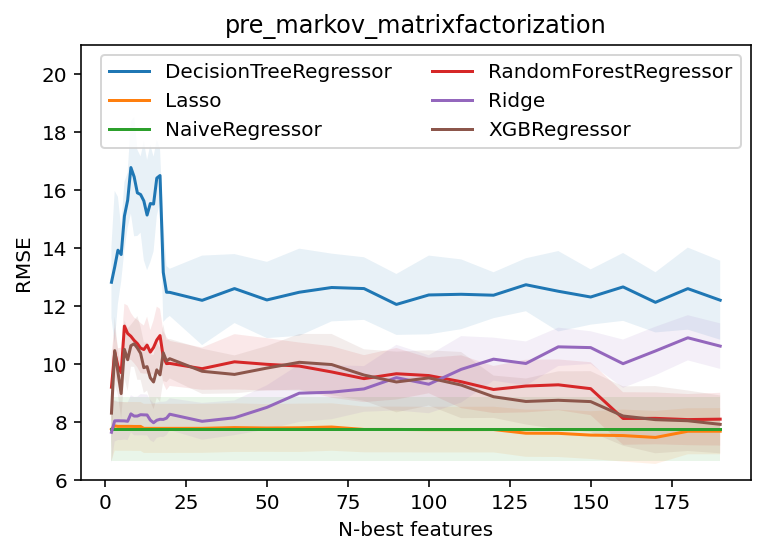

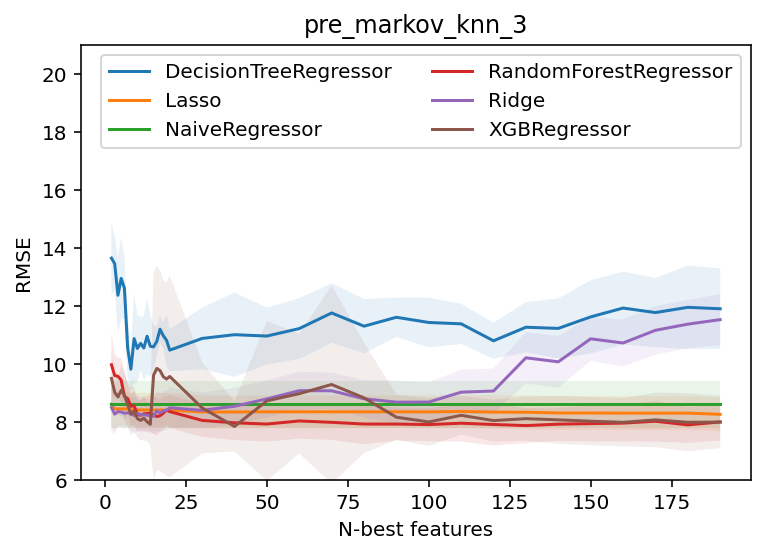

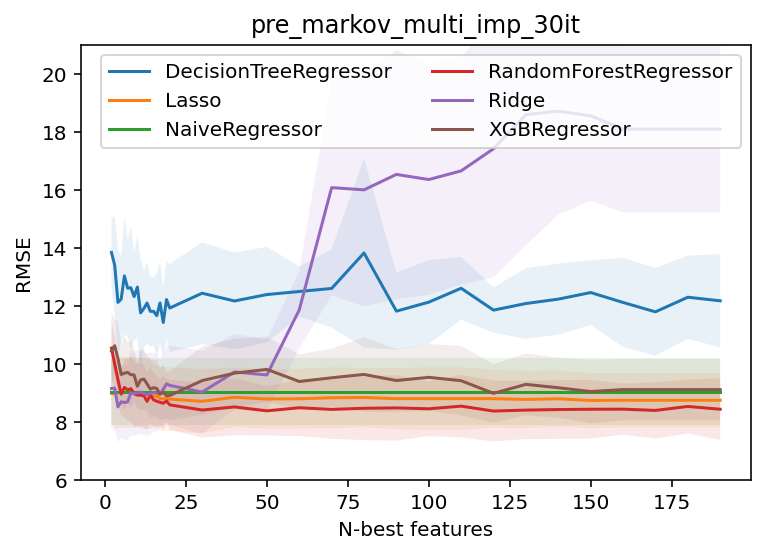

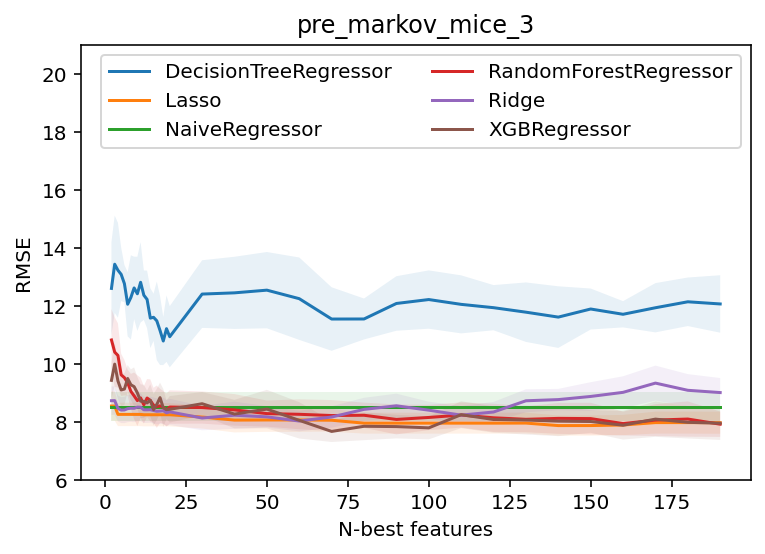

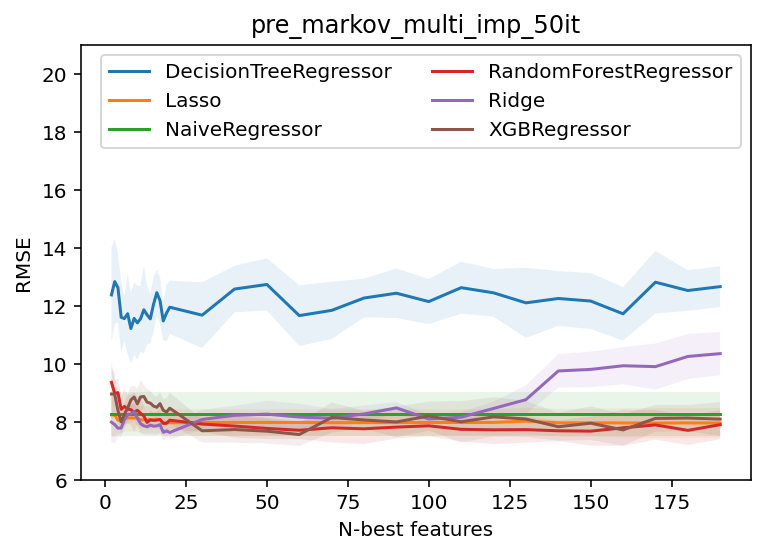

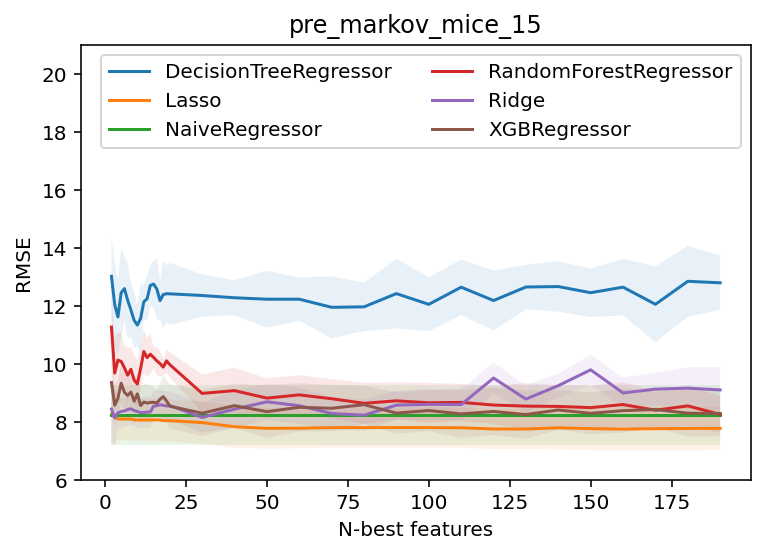

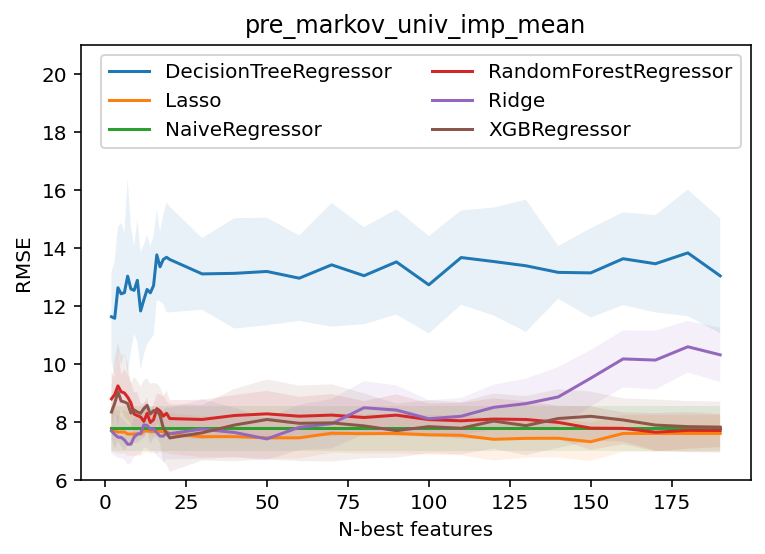

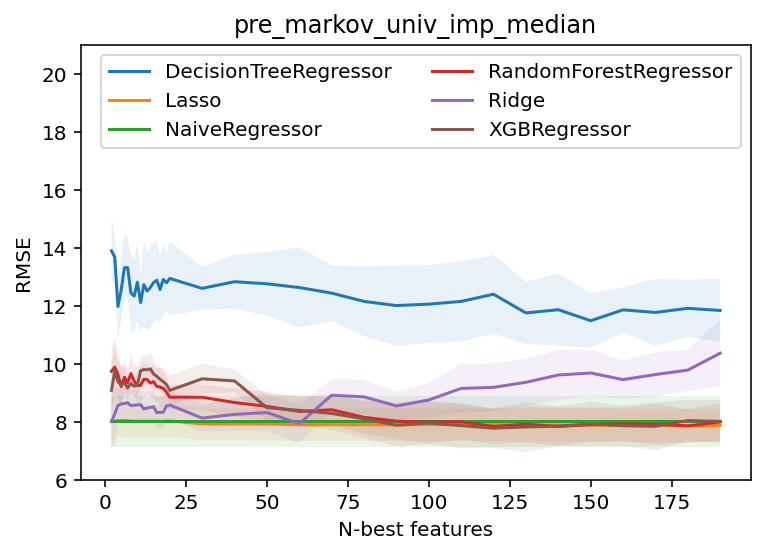

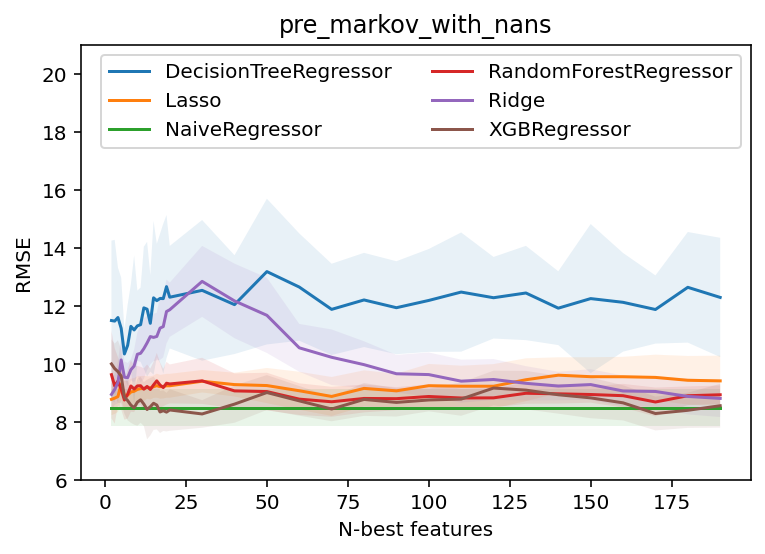

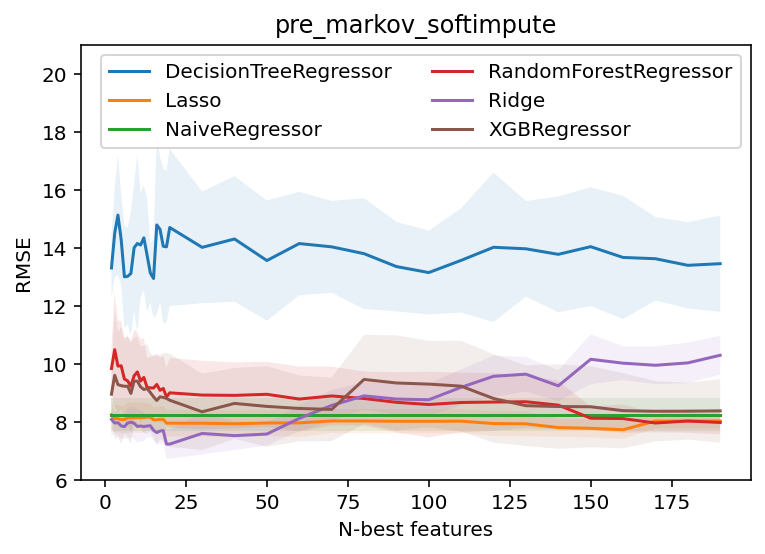

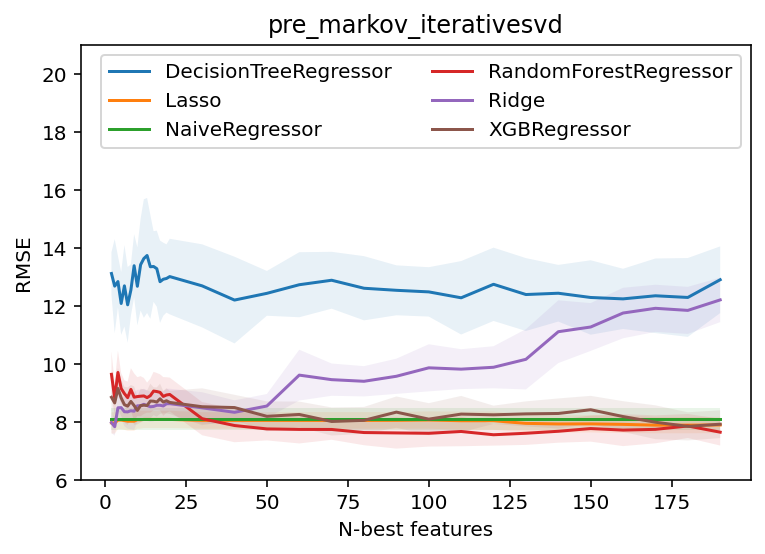

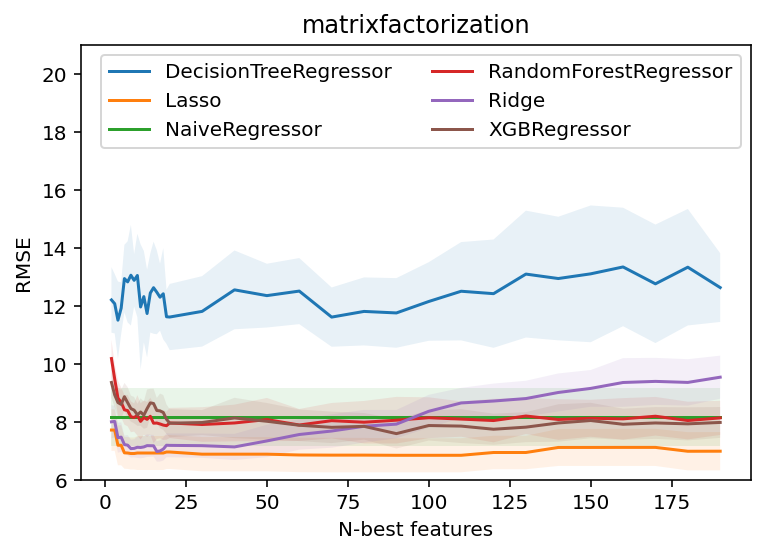

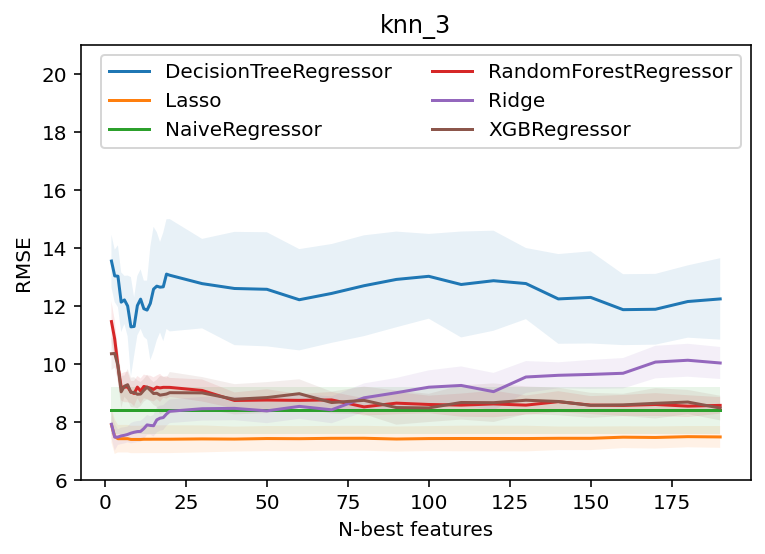

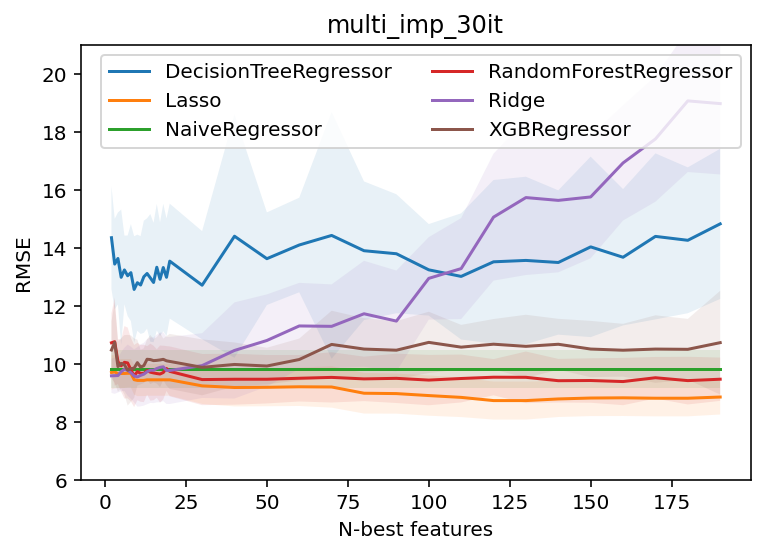

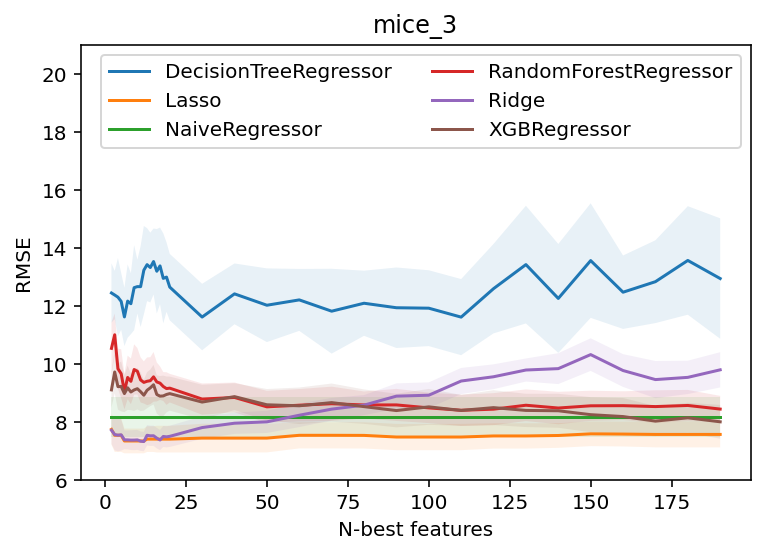

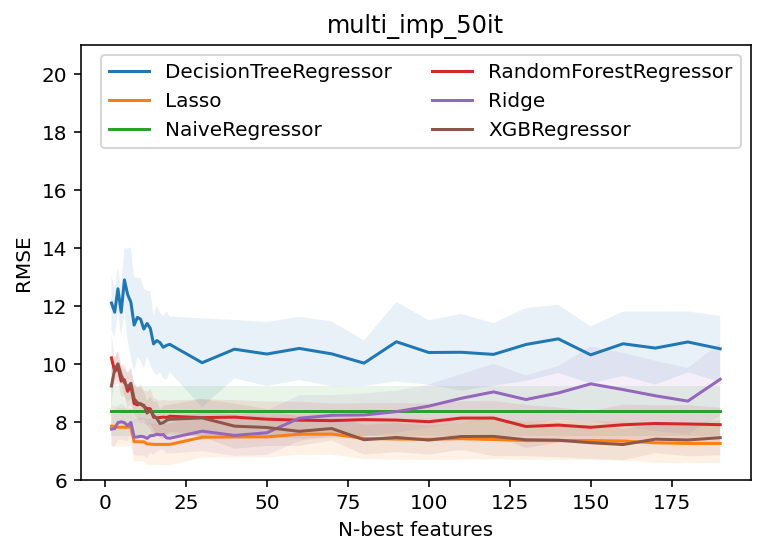

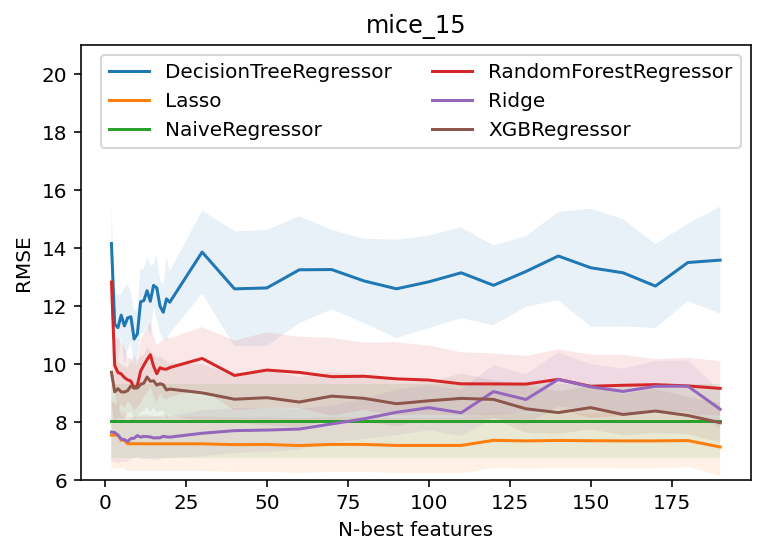

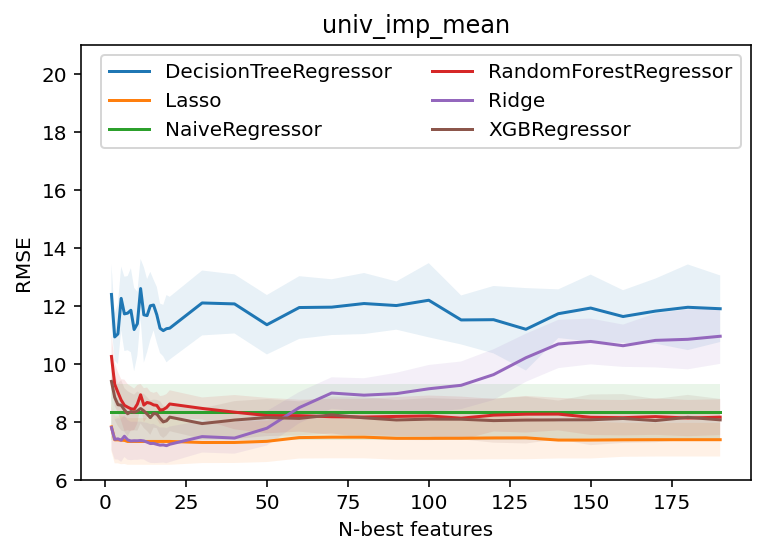

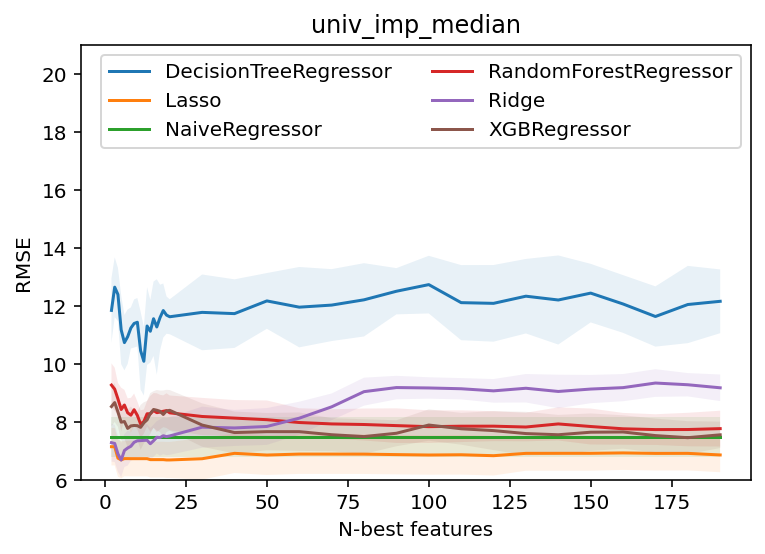

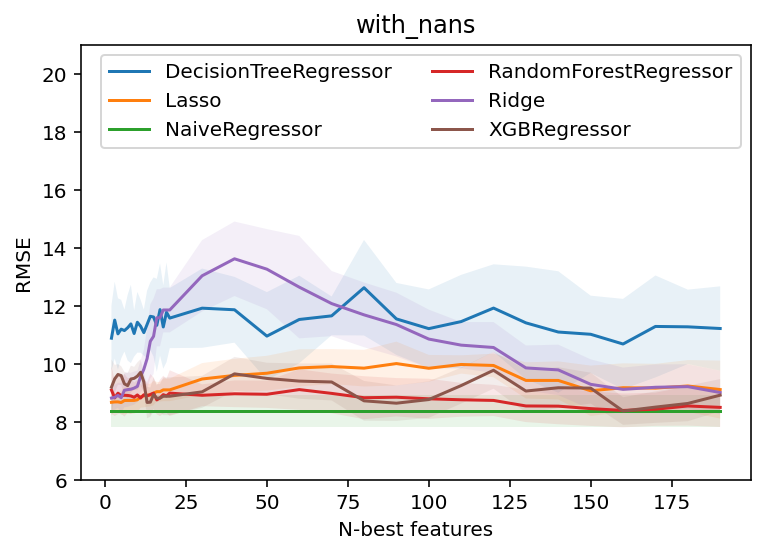

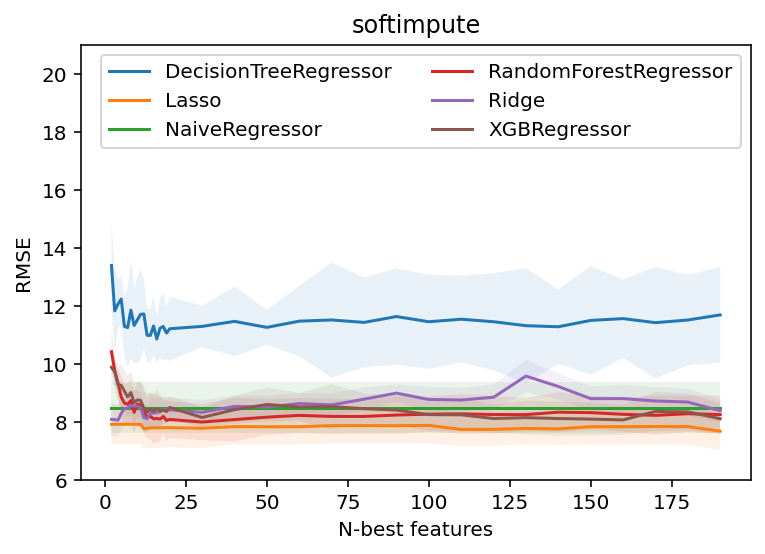

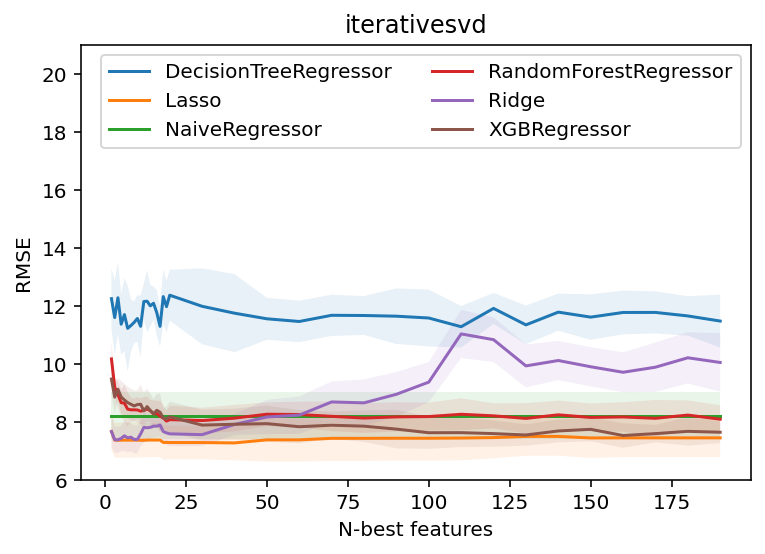

In [8]:
for dset in df.dataset.unique():
    _df = df[df.dataset == dset]
    _df = _df.groupby(['algorithm', 'n_features']).agg(['mean', 'std']).reset_index()
    fig, ax = plt.subplots(1,1)
    for alg in _df.algorithm.unique():
        _data = _df[_df.algorithm == alg] 
        _data.plot(x='n_features', y=('RMSE', 'mean'), label=alg, ax=ax)
        plt.fill_between(_data.n_features, _data['RMSE']['mean'] - _data['RMSE']['std'], _data['RMSE']['mean'] + _data['RMSE']['std'], alpha=0.1)
        plt.ylim(6, 21)
    plt.ylabel("RMSE")
    plt.xlabel('N-best features')
    plt.title(dset)
    plt.legend(ncol=2)
    plt.savefig(FIGSDIR/f'result_algs_{dset}.png', dpi=500)
    plt.show()

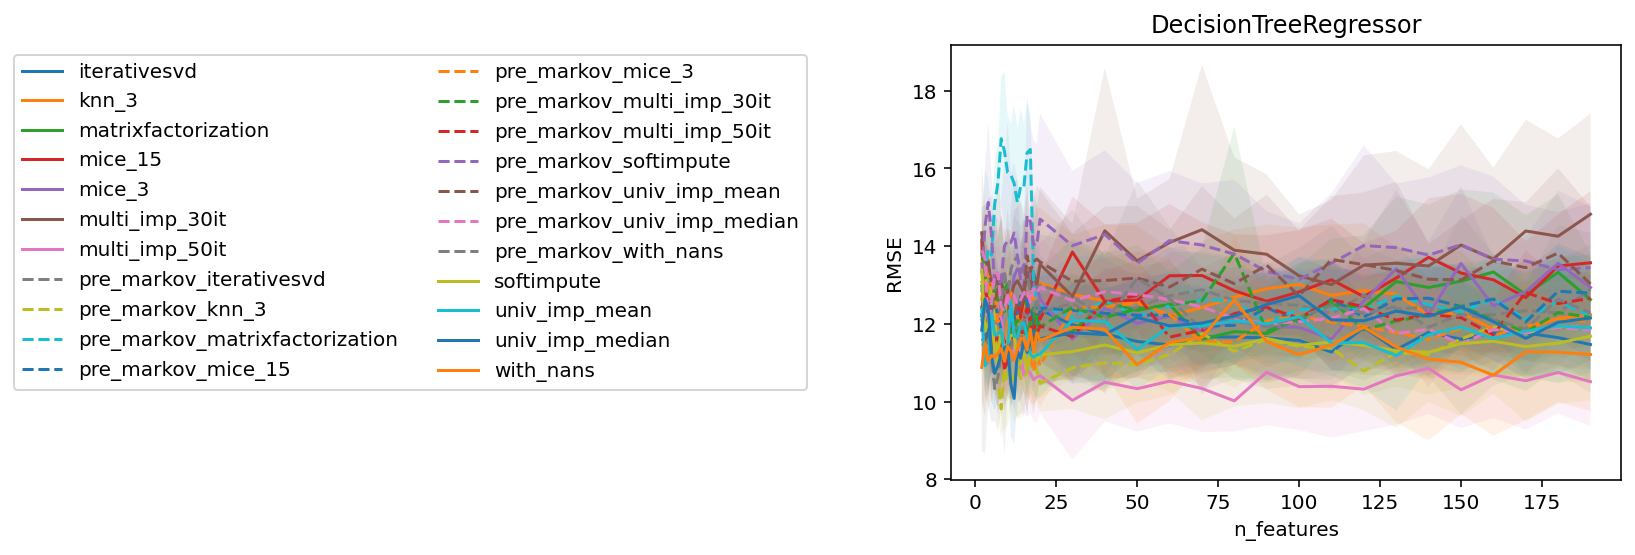

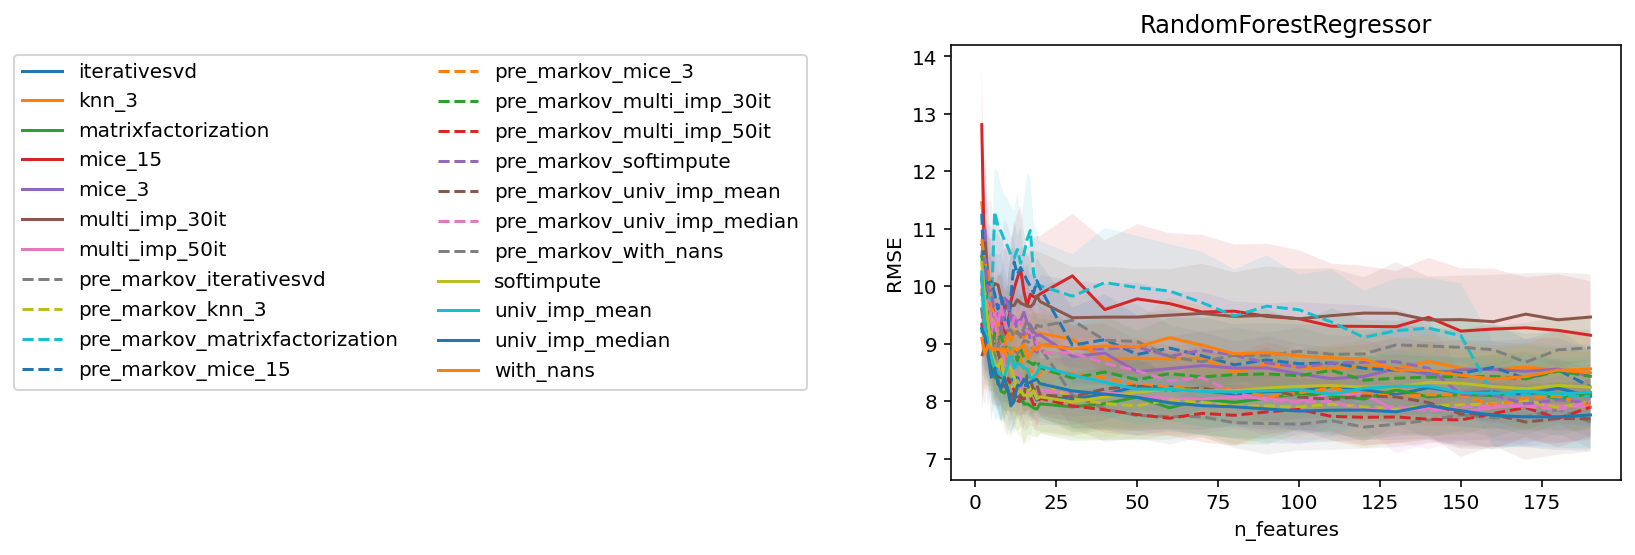

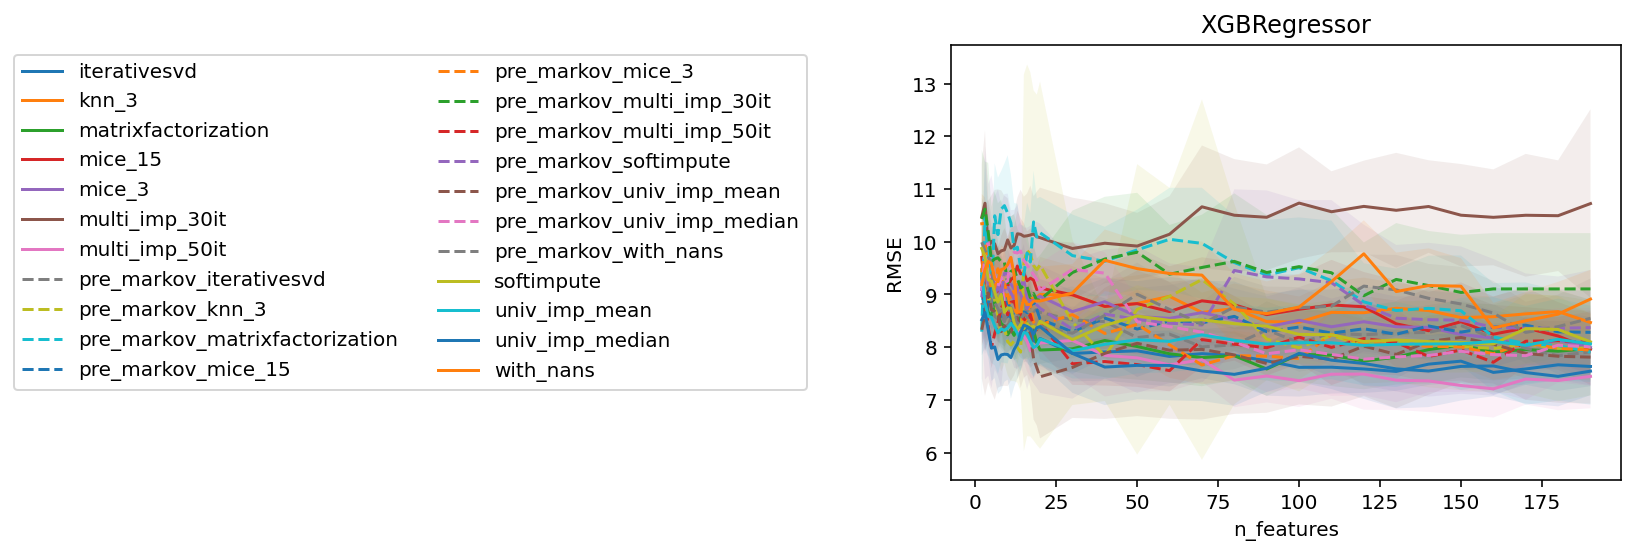

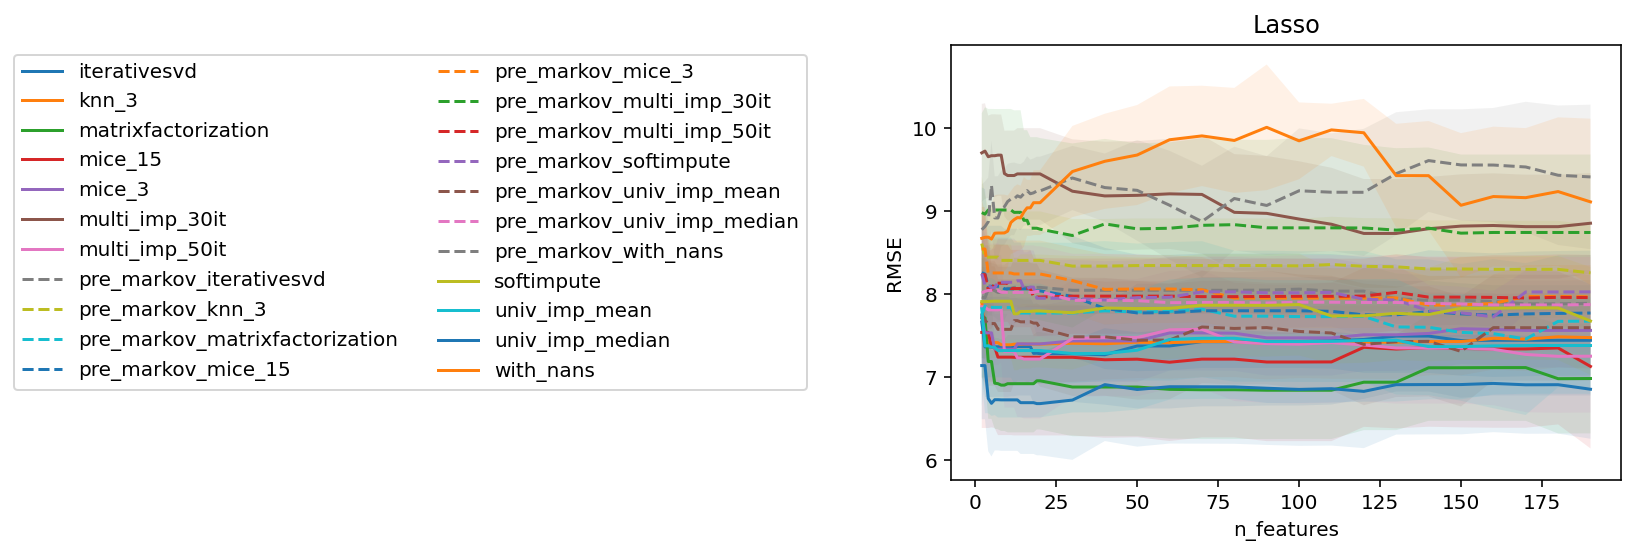

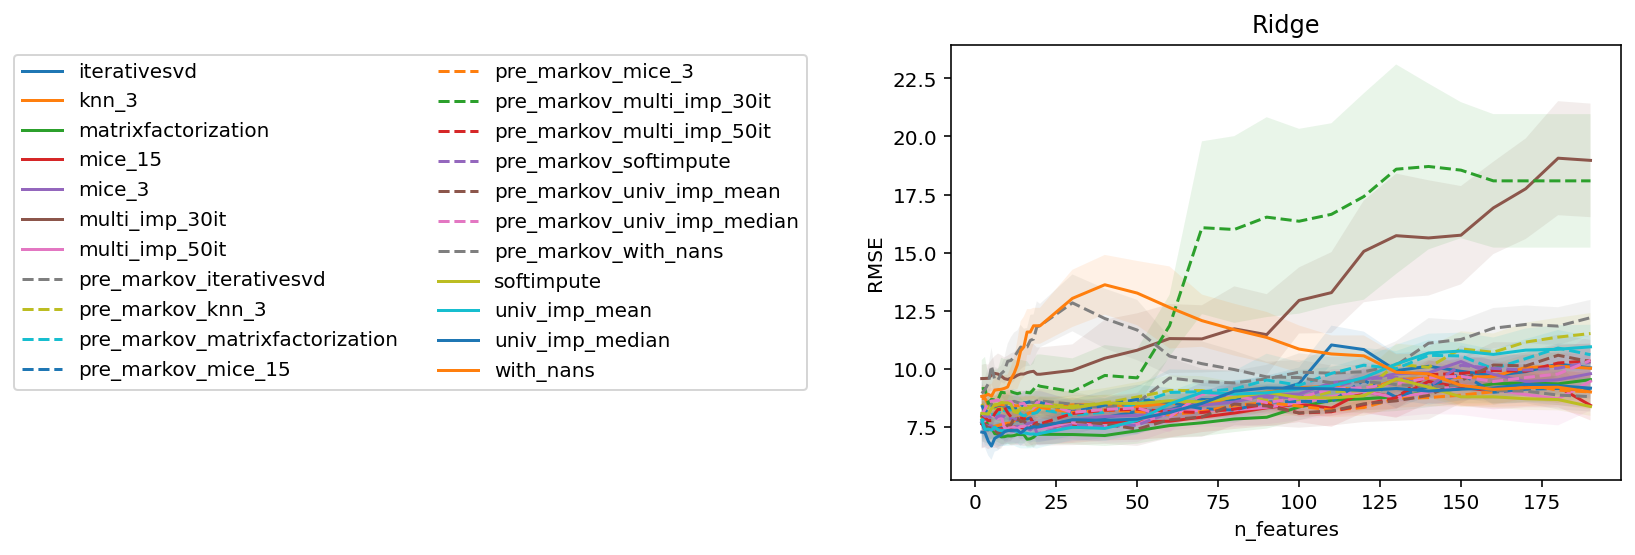

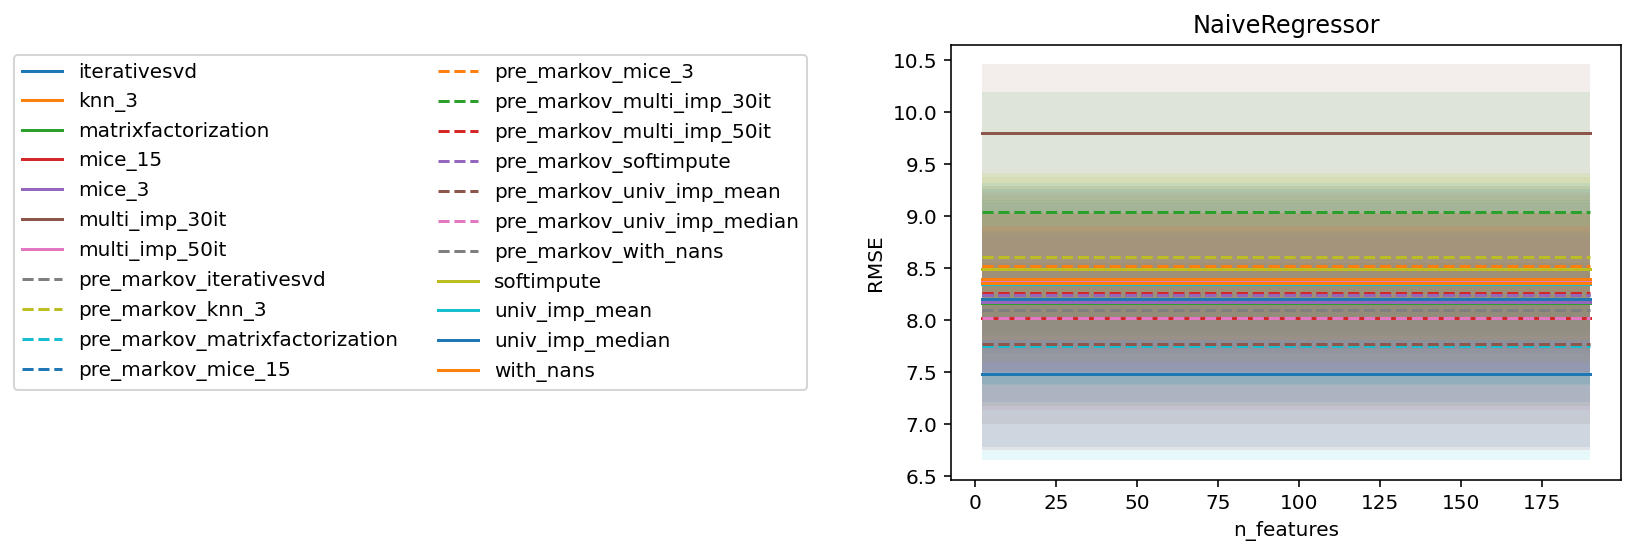

In [9]:
for alg in df.algorithm.unique():
    _df = df[df.algorithm == alg]
    _df = _df.groupby(['dataset', 'n_features']).agg(['mean', 'std']).reset_index()
    fig, ax = plt.subplots(1,1)
    for dset in _df.dataset.unique():
        _data = _df[_df.dataset == dset]
        if all(_data[('markov', 'mean')] > 0):
            linestyle = '-'
        else:
            linestyle = '--'
        
        _data.plot(x='n_features', y=('RMSE', 'mean'), label=dset, ax=ax, linestyle=linestyle)
        plt.fill_between(_data.n_features, _data['RMSE']['mean'] - _data['RMSE']['std'], _data['RMSE']['mean'] + _data['RMSE']['std'], alpha=0.1)
#         plt.ylim(7, 18)
    plt.ylabel("RMSE")
    plt.title(alg)
    plt.legend(ncol=2, loc='upper right', bbox_to_anchor=(-0.2, 1))
    plt.savefig(FIGSDIR/f'result_dsets_{alg}.png', dpi=500)
    plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47520 entries, 0 to 47519
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dataset         47520 non-null  object 
 1   algorithm       47520 non-null  object 
 2   n_features      47520 non-null  int64  
 3   train_examples  47520 non-null  int64  
 4   RMSE            47520 non-null  float64
 5   markov          47520 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.2+ MB


In [11]:
df.algorithm.unique()

array(['DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor',
       'Lasso', 'Ridge', 'NaiveRegressor'], dtype=object)

In [12]:
df.dataset.unique()

array(['pre_markov_matrixfactorization', 'pre_markov_knn_3',
       'pre_markov_multi_imp_30it', 'pre_markov_mice_3',
       'pre_markov_multi_imp_50it', 'pre_markov_mice_15',
       'pre_markov_univ_imp_mean', 'pre_markov_univ_imp_median',
       'pre_markov_with_nans', 'pre_markov_softimpute',
       'pre_markov_iterativesvd', 'matrixfactorization', 'knn_3',
       'multi_imp_30it', 'mice_3', 'multi_imp_50it', 'mice_15',
       'univ_imp_mean', 'univ_imp_median', 'with_nans', 'softimpute',
       'iterativesvd'], dtype=object)

In [13]:
_df = df.groupby(['algorithm', 'dataset', 'n_features']).agg(['mean', 'std'])['RMSE'].sort_values('mean', ascending=True).reset_index()
_df.head(30).round(2)

algorithm              dataset  n_features  mean   std
0      Ridge      univ_imp_median           5  6.67  0.59
1      Lasso      univ_imp_median          19  6.68  0.62
2      Lasso      univ_imp_median          20  6.68  0.62
3      Lasso      univ_imp_median           5  6.68  0.64
4      Lasso      univ_imp_median          16  6.69  0.62
5      Lasso      univ_imp_median          17  6.69  0.62
6      Lasso      univ_imp_median          18  6.69  0.62
7      Lasso      univ_imp_median          14  6.69  0.62
8      Lasso      univ_imp_median          15  6.69  0.62
9      Lasso      univ_imp_median          30  6.72  0.72
10     Lasso      univ_imp_median           9  6.72  0.61
11     Lasso      univ_imp_median          10  6.72  0.61
12     Lasso      univ_imp_median          13  6.72  0.61
13     Lasso      univ_imp_median          12  6.72  0.61
14     Lasso      univ_imp_median          11  6.72  0.61
15     Lasso      univ_imp_median           8  6.72  0.61
16     Lasso      univ_imp_median           7  6.72  0.61
17     Lasso      univ_imp_median           6  6.72  0.61
18     Lasso      univ_imp_median           4  6.74  0.64
19     Lasso      univ_imp_median         120  6.82  0.68
20     Lasso  matrixfactorization          90  6.84  0.59
21     Lasso  matrixfactorization         100  6.84  0.59
22     Lasso  matrixfactorization         110  6.84  0.59
23     Lasso  matrixfactorization          70  6.84  0.59
24     Lasso  matrixfactorization          80  6.84  0.59
25     Lasso      univ_imp_median          50  6.85  0.69
26     Lasso      univ_imp_median         100  6.85  0.68
27     Lasso  matrixfactorization          60  6.85  0.59
28     Lasso      univ_imp_median         190  6.85  0.60
29     Lasso      univ_imp_median         110  6.86  0.68

In [14]:
from collections import defaultdict

_df = df.groupby(['algorithm', 'dataset', 'n_features']).agg(['mean', 'std'])['RMSE'].sort_values('mean', ascending=True).reset_index()
bests = defaultdict(dict)
for alg in df.algorithm.unique():
    for dset in df.dataset.unique():
        bests[dset][alg] = _df[(_df.algorithm == alg) & (_df.dataset == dset)].head(1)['mean'].values[0]
bests = pd.DataFrame(bests)

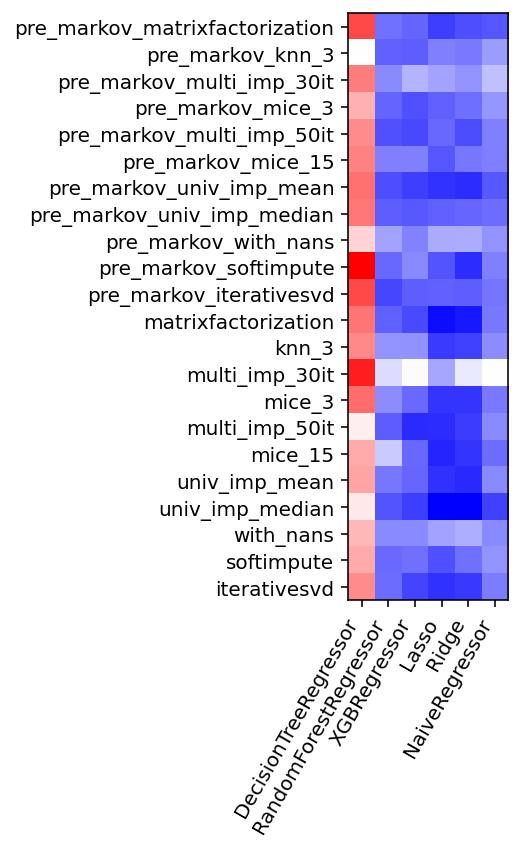

In [15]:
dsets, algs = list(df.dataset.unique()), list(df.algorithm.unique())
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(bests.T, cmap='bwr')
plt.yticks(np.arange(len(dsets)), labels=dsets)
plt.xticks(np.arange(len(algs)), labels=algs, rotation=60, ha='right')
plt.tight_layout()
plt.savefig(FIGSDIR/f'result_RMSE_heatmap.eps')
plt.show()

In [16]:
bests.T.round(2)

DecisionTreeRegressor  RandomForestRegressor  \
pre_markov_matrixfactorization                  12.04                   8.07   
pre_markov_knn_3                                 9.81                   7.86   
pre_markov_multi_imp_30it                       11.42                   8.36   
pre_markov_mice_3                               10.78                   7.91   
pre_markov_multi_imp_50it                       11.21                   7.67   
pre_markov_mice_15                              11.33                   8.25   
pre_markov_univ_imp_mean                        11.56                   7.64   
pre_markov_univ_imp_median                      11.48                   7.83   
pre_markov_with_nans                            10.33                   8.68   
pre_markov_softimpute                           12.94                   7.95   
pre_markov_iterativesvd                         12.03                   7.55   
matrixfactorization                             11.50                   7.86   
knn_3                                           11.27                   8.51   
multi_imp_30it                                  12.56                   9.38   
mice_3                                          11.60                   8.39   
multi_imp_50it                                  10.02                   7.80   
mice_15                                         10.85                   9.15   
univ_imp_mean                                   10.92                   8.12   
univ_imp_median                                 10.08                   7.73   
with_nans                                       10.68                   8.39   
softimpute                                      10.85                   7.99   
iterativesvd                                    11.22                   8.02   

                                XGBRegressor  Lasso  Ridge  NaiveRegressor  
pre_markov_matrixfactorization          7.91   7.45   7.63            7.75  
pre_markov_knn_3                        7.83   8.25   8.18            8.60  
pre_markov_multi_imp_30it               8.89   8.70   8.51            9.04  
pre_markov_mice_3                       7.66   7.86   8.02            8.52  
pre_markov_multi_imp_50it               7.55   7.95   7.63            8.26  
pre_markov_mice_15                      8.24   7.74   8.13            8.23  
pre_markov_univ_imp_mean                7.44   7.31   7.22            7.77  
pre_markov_univ_imp_median              7.77   7.86   7.93            8.02  
pre_markov_with_nans                    8.26   8.77   8.80            8.48  
pre_markov_softimpute                   8.34   7.72   7.22            8.24  
pre_markov_iterativesvd                 7.84   7.88   7.82            8.09  
matrixfactorization                     7.59   6.84   6.97            8.16  
knn_3                                   8.47   7.39   7.46            8.39  
multi_imp_30it                          9.77   8.73   9.54            9.80  
mice_3                                  7.99   7.33   7.31            8.17  
multi_imp_50it                          7.21   7.21   7.42            8.36  
mice_15                                 7.96   7.13   7.31            8.01  
univ_imp_mean                           7.93   7.28   7.17            8.34  
univ_imp_median                         7.45   6.68   6.67            7.47  
with_nans                               8.36   8.66   8.81            8.35  
softimpute                              8.06   7.67   8.05            8.49  
iterativesvd                            7.52   7.27   7.37            8.20

In [17]:
bests = bests.T.reset_index()
bests.rename({'index': 'dataset'}, axis=1, inplace=True)

In [18]:
bests['markov'] = bests['dataset'].apply(lambda s: 0 if s[:3] == 'pre' else 1)
bests

dataset  DecisionTreeRegressor  \
0   pre_markov_matrixfactorization              12.042070   
1                 pre_markov_knn_3               9.808452   
2        pre_markov_multi_imp_30it              11.417601   
3                pre_markov_mice_3              10.780196   
4        pre_markov_multi_imp_50it              11.210958   
5               pre_markov_mice_15              11.329807   
6         pre_markov_univ_imp_mean              11.562902   
7       pre_markov_univ_imp_median              11.480609   
8             pre_markov_with_nans              10.333456   
9            pre_markov_softimpute              12.936408   
10         pre_markov_iterativesvd              12.028585   
11             matrixfactorization              11.498740   
12                           knn_3              11.268394   
13                  multi_imp_30it              12.559143   
14                          mice_3              11.604209   
15                  multi_imp_50it              10.017400   
16                         mice_15              10.849108   
17                   univ_imp_mean              10.921062   
18                 univ_imp_median              10.080790   
19                       with_nans              10.676682   
20                      softimpute              10.849787   
21                    iterativesvd              11.217489   

    RandomForestRegressor  XGBRegressor     Lasso     Ridge  NaiveRegressor  \
0                8.070030      7.906086  7.454164  7.632443        7.746439   
1                7.863051      7.834049  8.250304  8.182553        8.603712   
2                8.364168      8.888698  8.700170  8.507946        9.038189   
3                7.910796      7.661493  7.863006  8.019499        8.516469   
4                7.671174      7.554803  7.948638  7.626416        8.260898   
5                8.247343      8.244044  7.741958  8.125514        8.232740   
6                7.635417      7.437229  7.306147  7.219308        7.768420   
7                7.829676      7.771980  7.864743  7.931409        8.015567   
8                8.676935      8.264126  8.769869  8.800268        8.484189   
9                7.951720      8.339406  7.720743  7.222424        8.240145   
10               7.546770      7.836561  7.878208  7.824584        8.093729   
11               7.859268      7.585740  6.838321  6.970288        8.159941   
12               8.508097      8.467882  7.385209  7.464432        8.386906   
13               9.381676      9.772319  8.725177  9.540987        9.798115   
14               8.390366      7.993311  7.332343  7.312931        8.172010   
15               7.804978      7.209262  7.213857  7.420117        8.362350   
16               9.146273      7.961994  7.125028  7.311971        8.013372   
17               8.118169      7.932418  7.279734  7.170944        8.340886   
18               7.725222      7.445973  6.677381  6.673500        7.473725   
19               8.385767      8.364139  8.657851  8.812818        8.351945   
20               7.986373      8.059406  7.671479  8.047715        8.485596   
21               8.018031      7.520813  7.265014  7.370571        8.201423   

    markov  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       1  
12       1  
13       1  
14       1  
15       1  
16       1  
17       1  
18       1  
19       1  
20       1  
21       1

(2, 3)


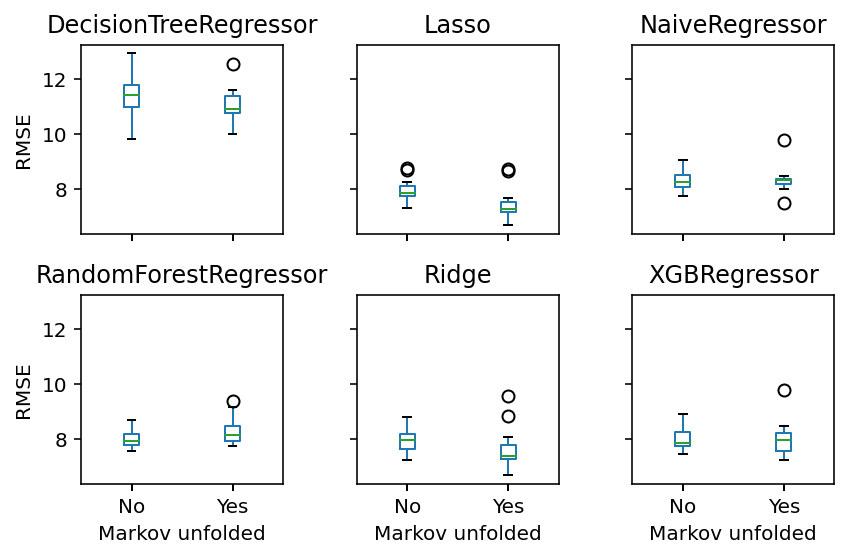

In [19]:
ax = bests.boxplot(by='markov', grid=False, layout=(2,3))
plt.suptitle('')
print(ax.shape)
for row in range(2):
    for col in range(3):
        ax[row][col].set_ylabel('RMSE')
        ax[row][col].set_xlabel('Markov unfolded')
        ax[row][col].set_xticklabels(['No', 'Yes'])
plt.tight_layout()
plt.savefig(FIGSDIR/f'result_markov_unfolding_boxes.eps')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


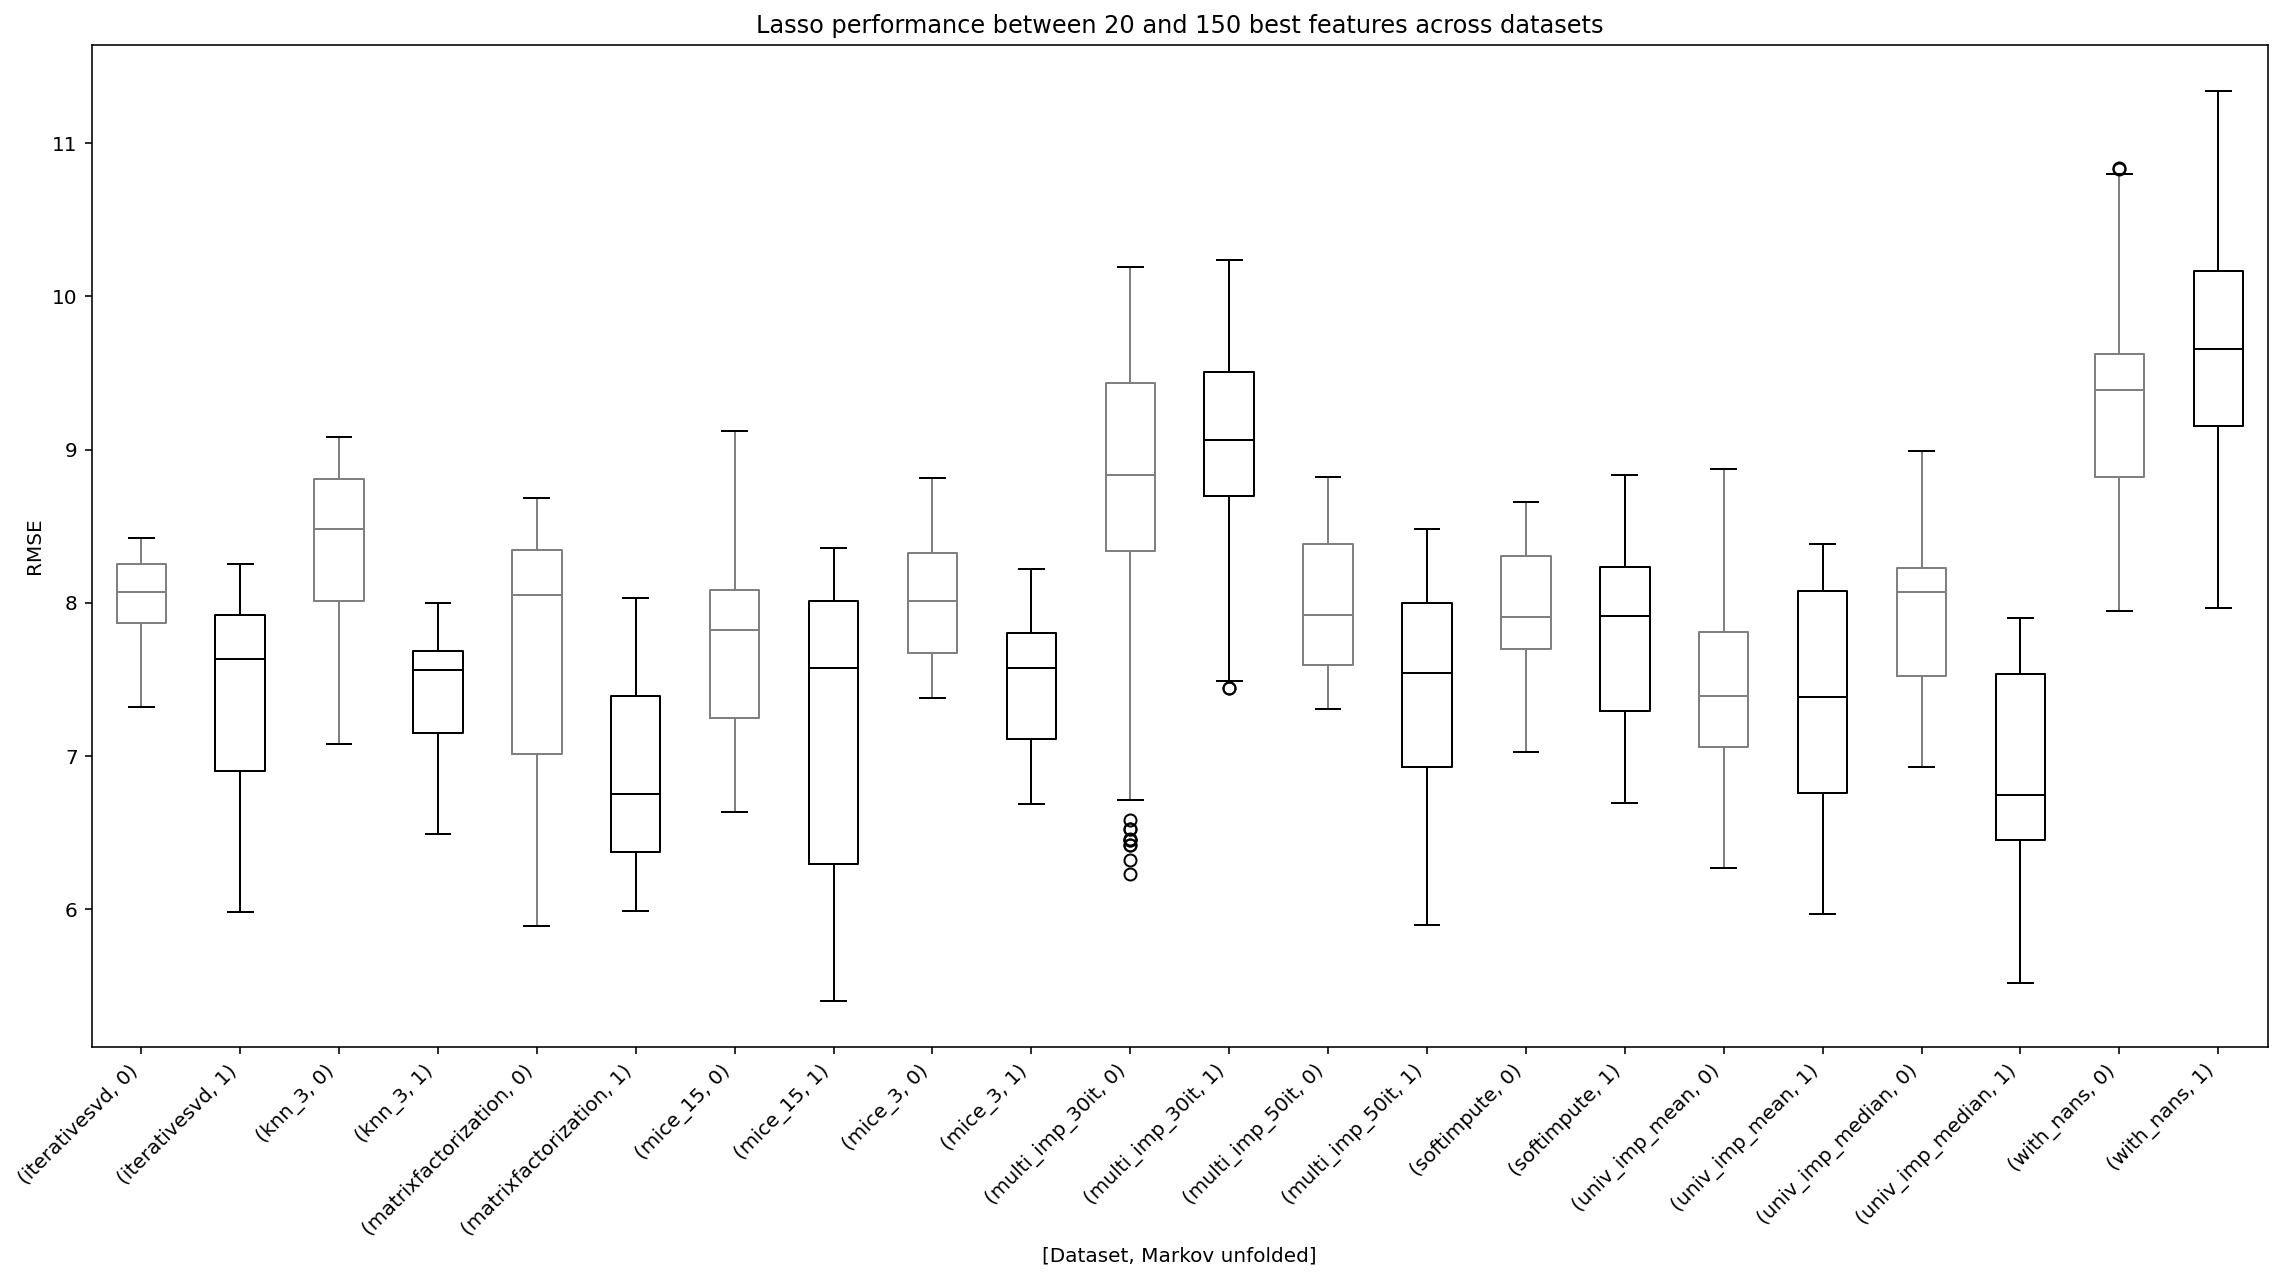

In [78]:
ft_range = (20, 150)

_df = df[(df.algorithm == 'Lasso') & (df.n_features.between(*ft_range))]
_df['markov'] = _df['dataset'].apply(lambda s: 0 if s[:3] == 'pre' else 1)
_df['dataset'] = _df['dataset'].apply(lambda s: s if not s.startswith('pre_markov') else s[11:])
lasso_bp = _df.boxplot(column='RMSE', by=['dataset', 'markov'], grid=False, notch=False, figsize=(16,9), return_type='dict')
for i, (box, median) in enumerate(zip(lasso_bp['RMSE']['boxes'], lasso_bp['RMSE']['medians'])):
    if i%2==0:
        box.set_color('grey')
        median.set_color('grey')
    else:
        box.set_color('black')
        median.set_color('black')
        
for i, whisker in enumerate(lasso_bp['RMSE']['whiskers']):
    if i%4<2:
        whisker.set_color('grey')
    else:
        whisker.set_color('black')
        
plt.xticks(rotation=45, ha='right')
plt.title(f'Lasso performance between {ft_range[0]} and {ft_range[1]} best features across datasets')
plt.suptitle('')
plt.ylabel('RMSE')
plt.xlabel('[Dataset, Markov unfolded]')
plt.tight_layout()
plt.savefig(FIGSDIR/'result_markov_lasso.eps')
plt.show()

In [65]:
lasso_bp['RMSE'].keys()

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])

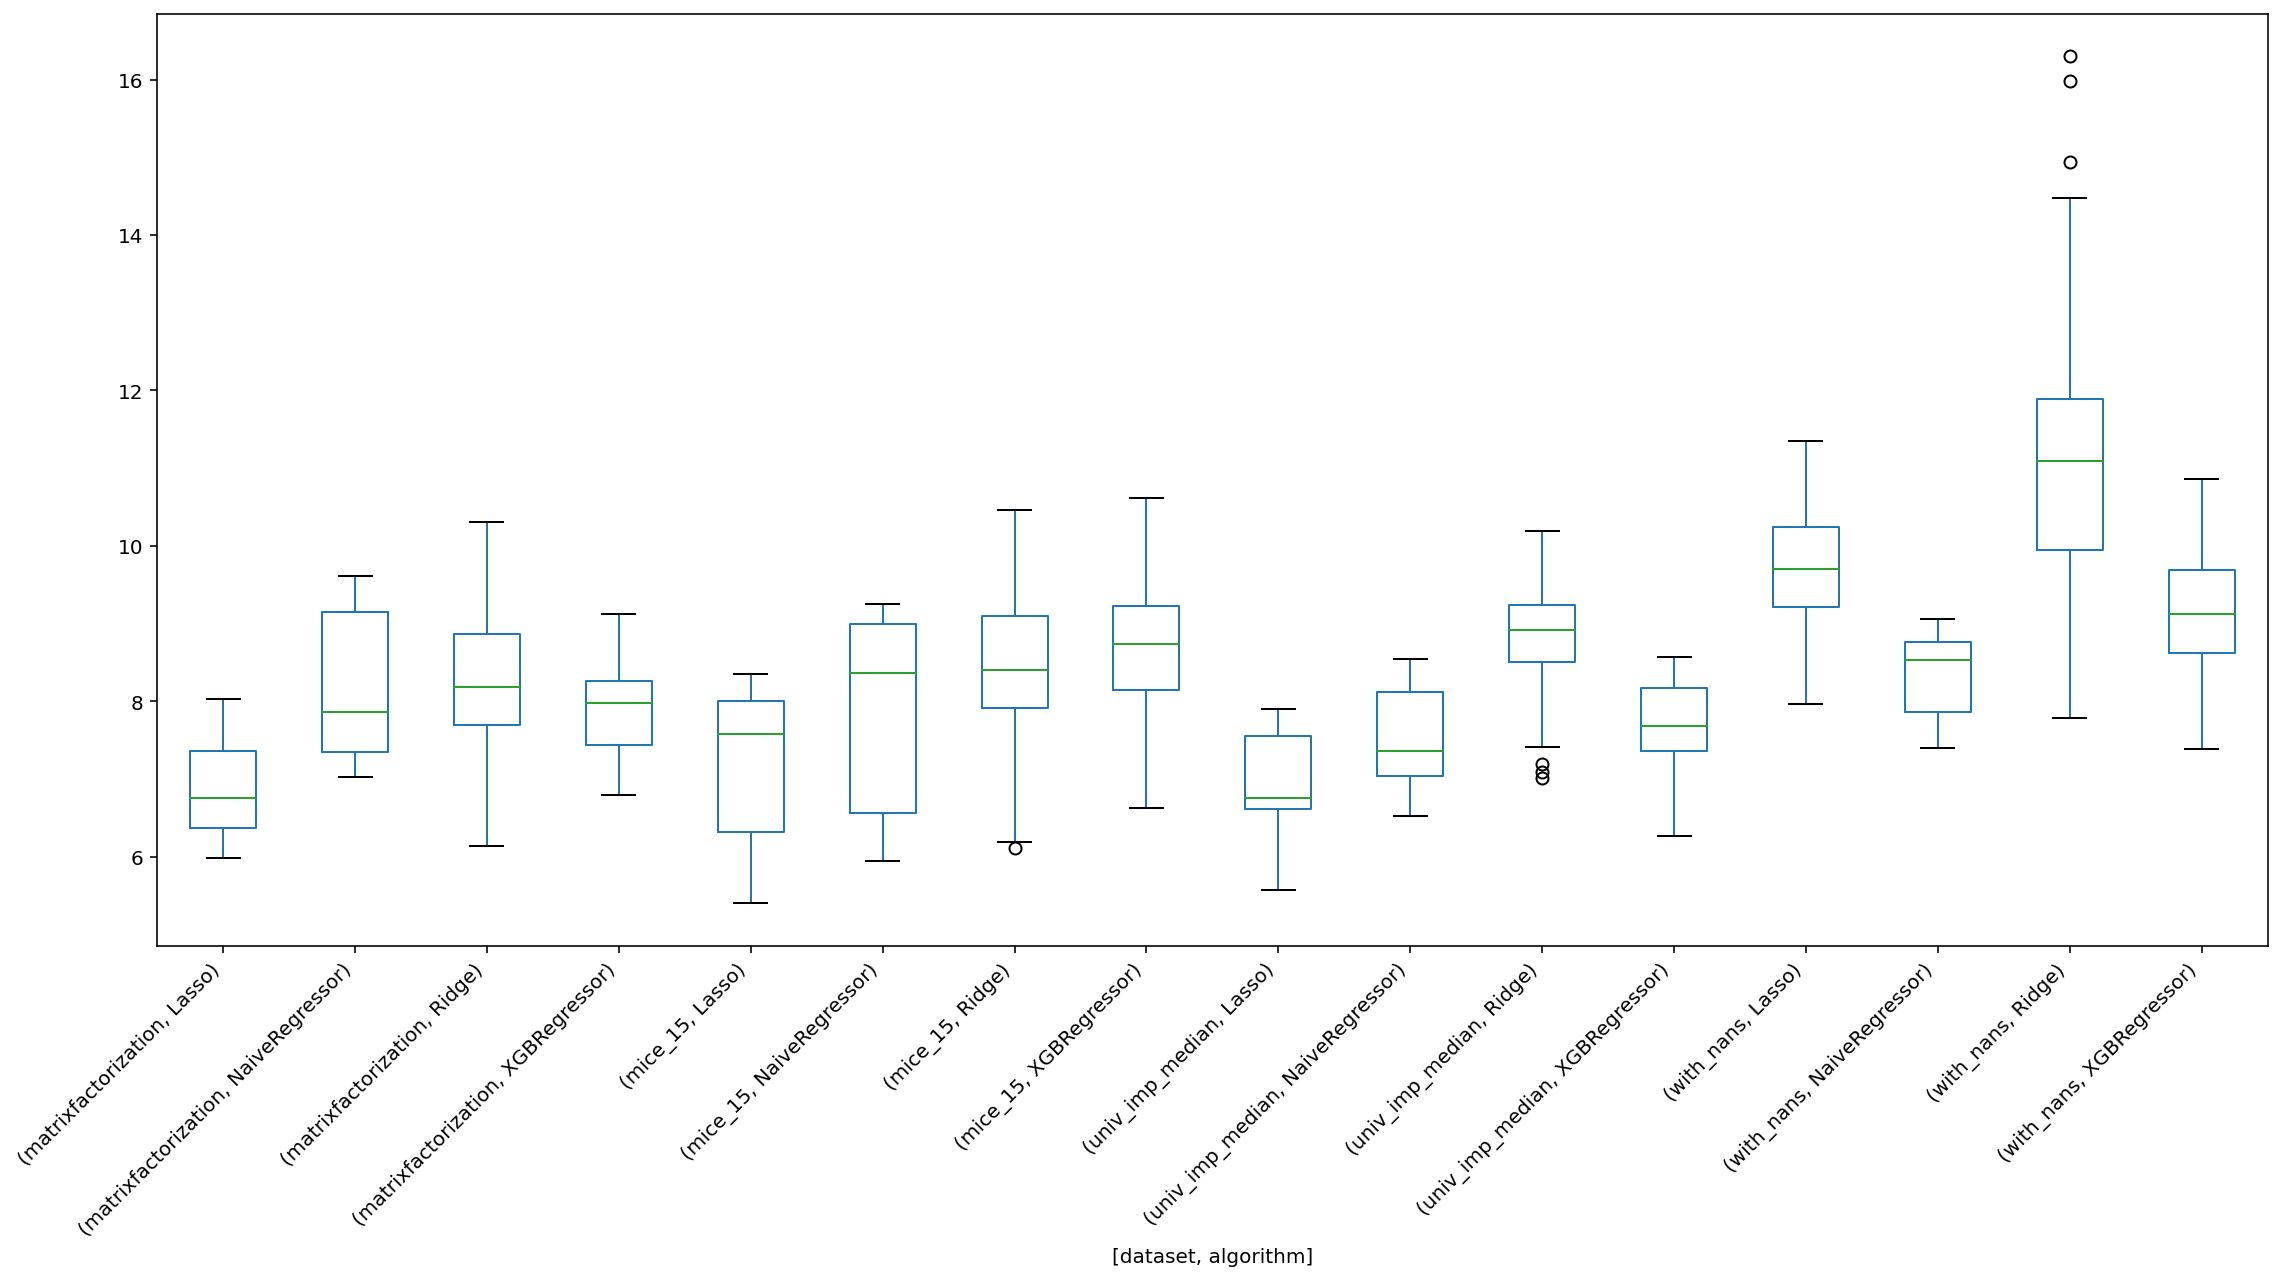

In [21]:
best_algs = [
    "NaiveRegressor",
    "Lasso",
    "Ridge",
    "XGBRegressor",
]

best_dsets = [
    'matrixfactorization', 
    'with_nans',
    'univ_imp_median',
    'mice_15',
    
]

ft_range = (50, 150)

_df = df[(df.algorithm.isin(best_algs)) & (df.dataset.isin(best_dsets)) & (df.n_features.between(*ft_range))]
_df.boxplot(column='RMSE', by=['dataset', 'algorithm'], grid=False, notch=False, figsize=(16,9),)
plt.xticks(rotation=45, ha='right')
plt.title('')
plt.suptitle('')
plt.tight_layout()
plt.savefig(FIGSDIR/'result_boxplot_algs.eps')
plt.show()

In [22]:
df.groupby(['dataset', 'algorithm', 'n_features']).agg({'RMSE': ['mean', 'std']}).sort_values(('RMSE', 'mean')).head(30)

RMSE          
                                              mean       std
dataset             algorithm n_features                    
univ_imp_median     Ridge     5           6.673500  0.592285
                    Lasso     19          6.677381  0.621550
                              20          6.677381  0.621550
                              5           6.680668  0.639135
                              18          6.688646  0.616930
                              17          6.688646  0.616930
                              16          6.688646  0.616930
                              15          6.688646  0.616930
                              14          6.688646  0.616930
                              30          6.720028  0.719261
                              10          6.722321  0.612961
                              12          6.722321  0.612961
                              11          6.722321  0.612961
                              9           6.722321  0.612961
                              8           6.722321  0.612961
                              13          6.722321  0.612961
                              7           6.724225  0.610223
                              6           6.724225  0.610223
                              4           6.739625  0.635218
                              120         6.824534  0.682916
matrixfactorization Lasso     90          6.838321  0.587004
                              100         6.838321  0.587004
                              110         6.838321  0.587004
                              70          6.843827  0.593181
                              80          6.844312  0.593110
univ_imp_median     Lasso     50          6.847267  0.687639
                              100         6.848264  0.678940
matrixfactorization Lasso     60          6.848957  0.592787
univ_imp_median     Lasso     190         6.850422  0.596106
                              110         6.856961  0.684293

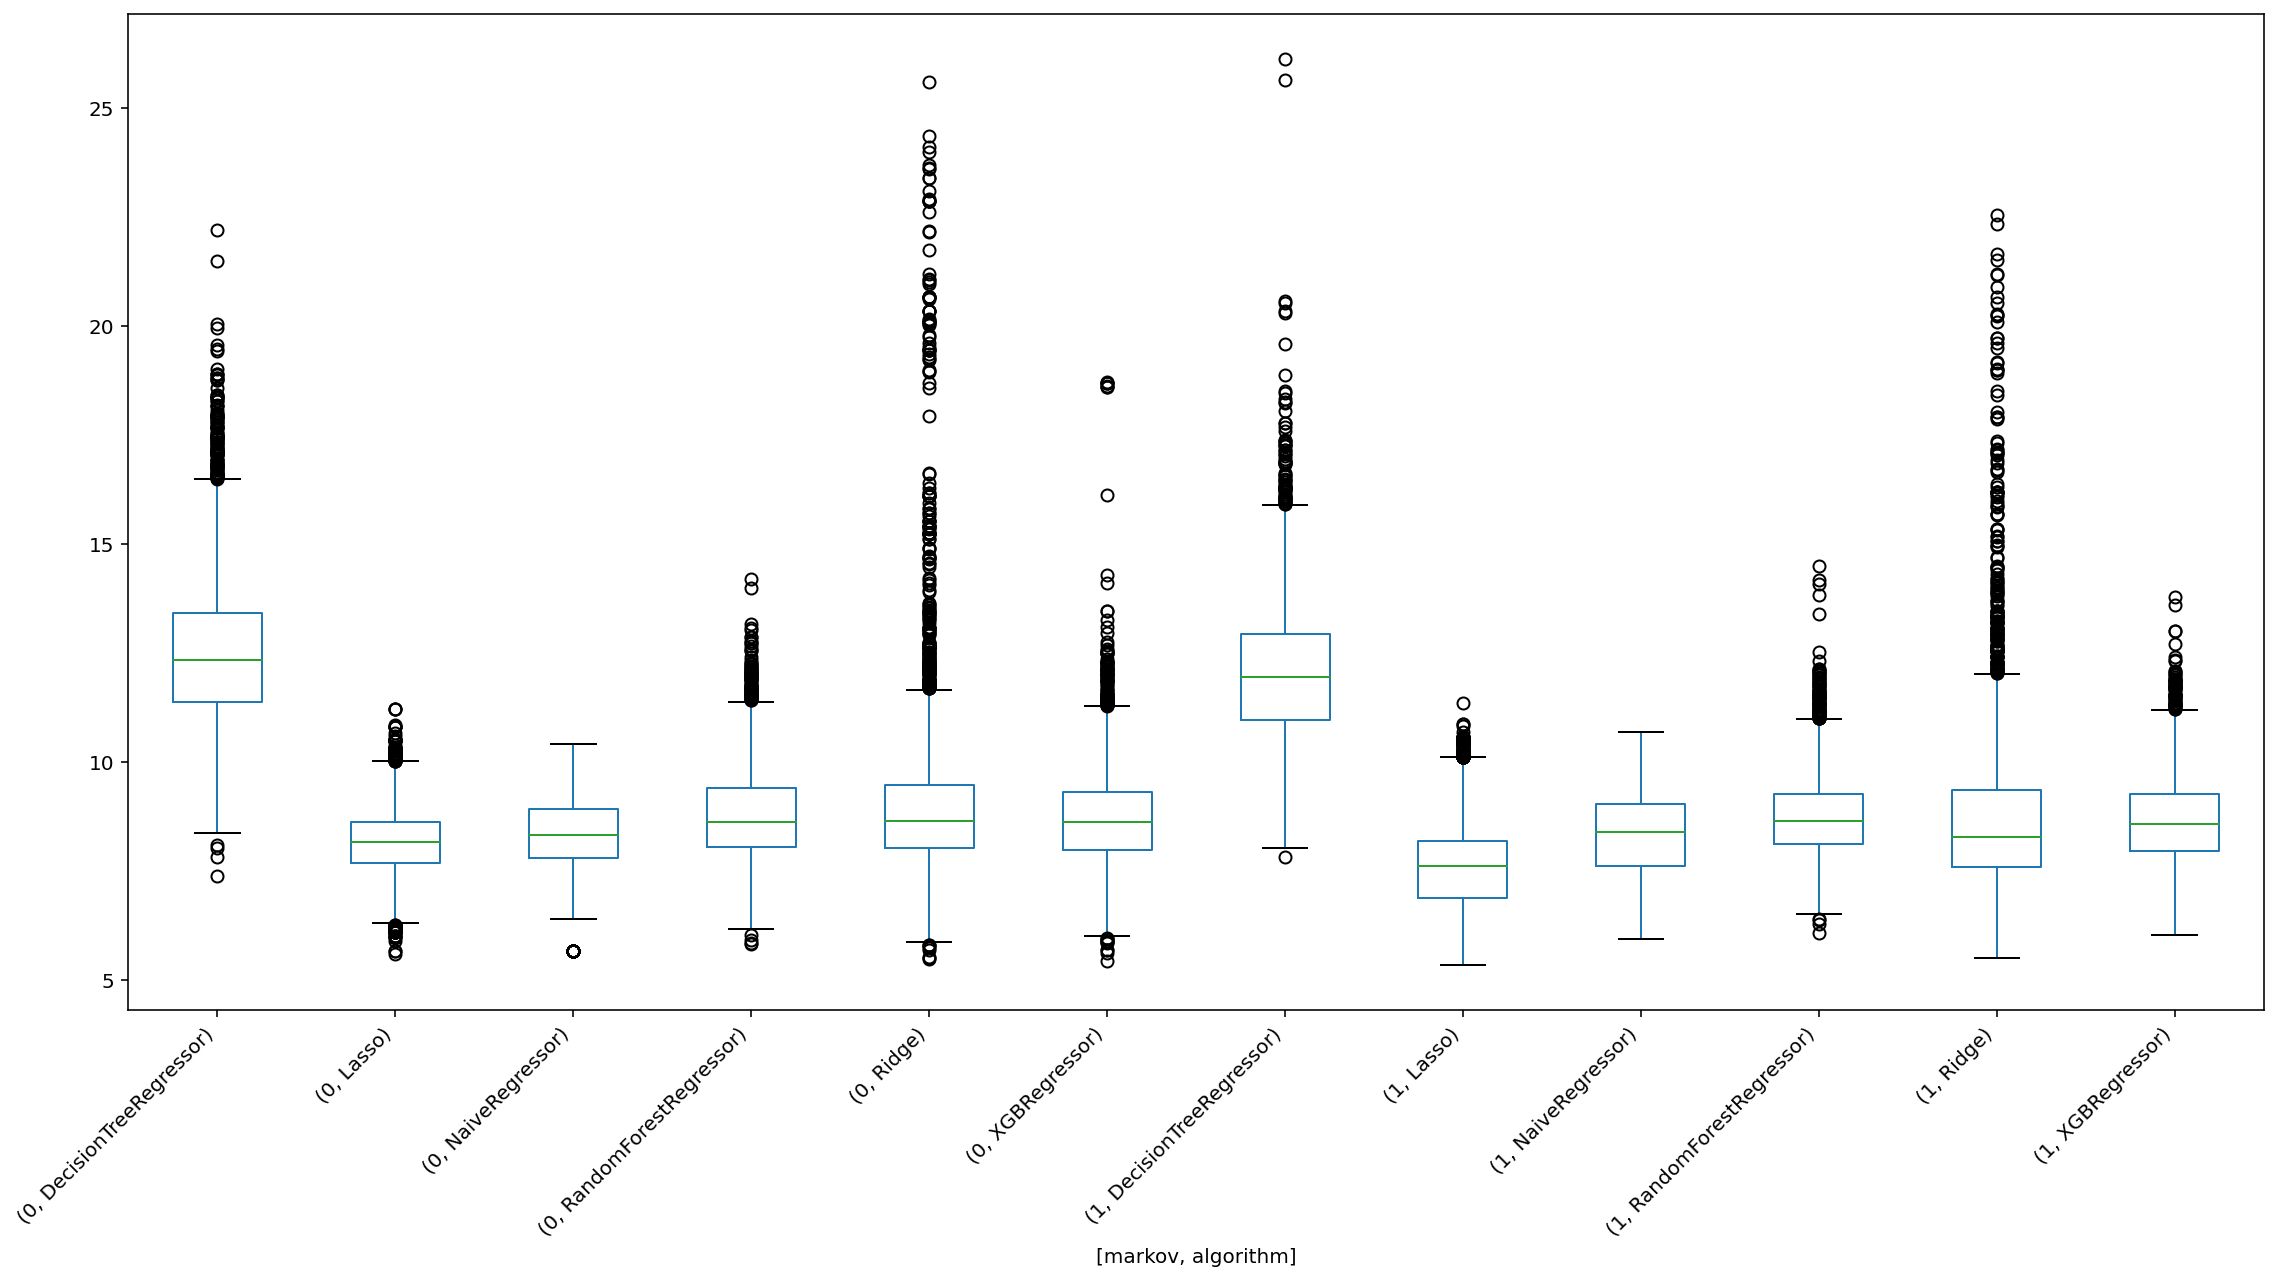

In [23]:
df.boxplot(column='RMSE', by=['markov', 'algorithm'], grid=False, notch=False, figsize=(16,9),)
plt.xticks(rotation=45, ha='right')
plt.title('')
plt.suptitle('')
plt.tight_layout()
plt.savefig(FIGSDIR/'result_boxplot_markov.eps')
plt.show()

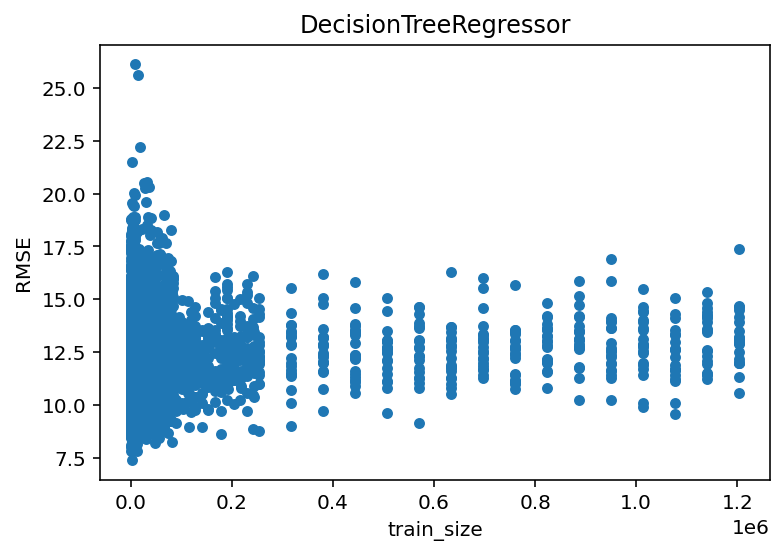

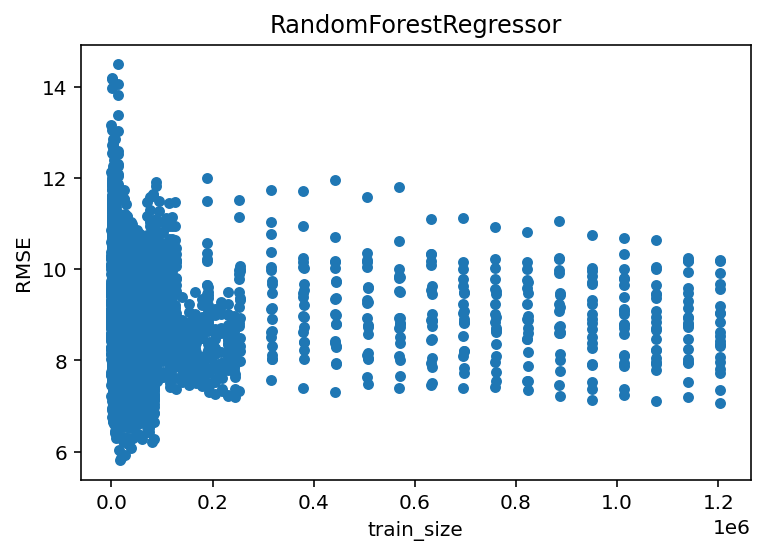

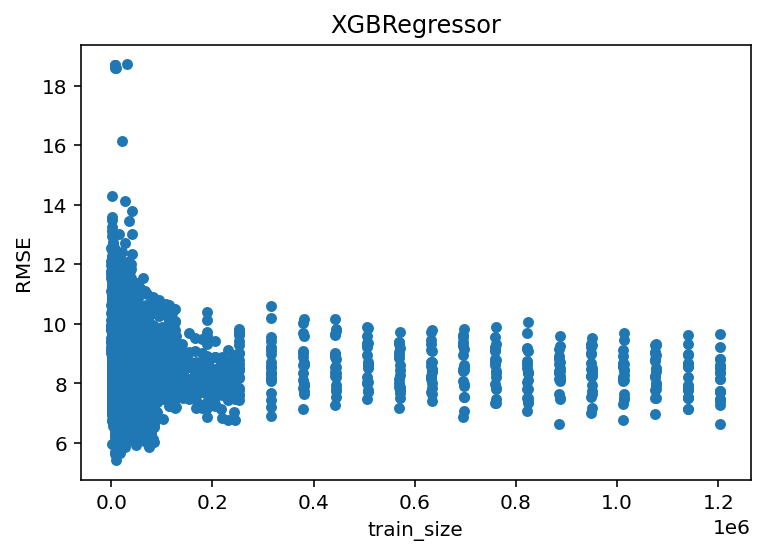

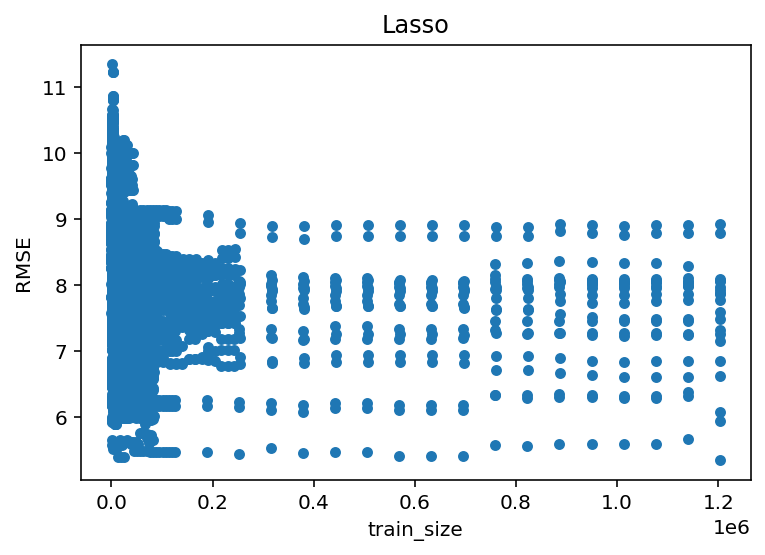

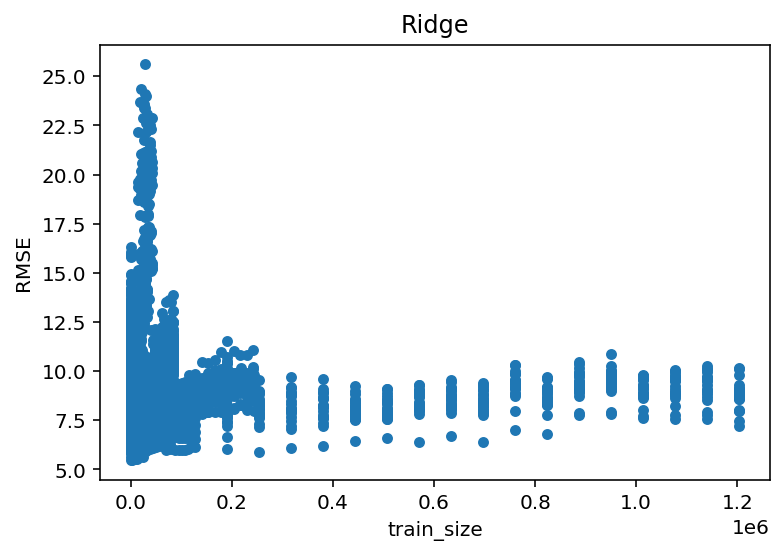

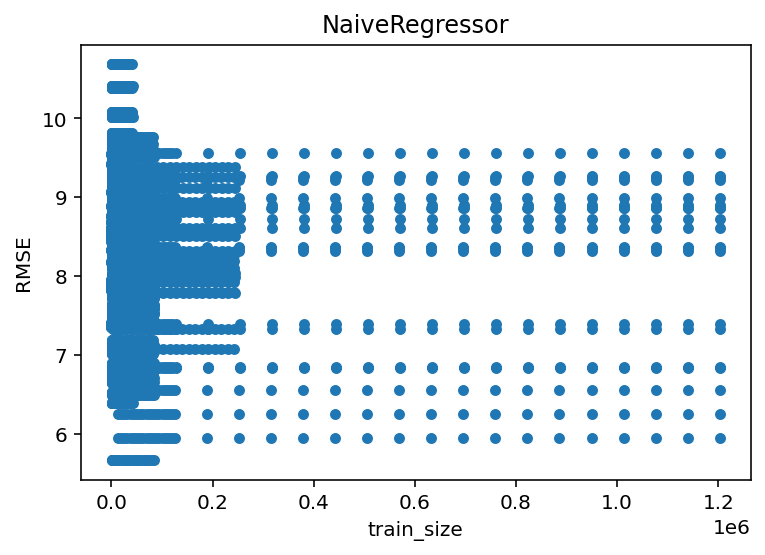

In [24]:
df['train_size'] = df['n_features'] * df['train_examples']
for alg in df.algorithm.unique():
    _df = df[df.algorithm == alg]
    _df.plot(kind='scatter', x='train_size', y='RMSE', title=alg)
    plt.show()